# Genome-scale characterization of RNA export

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/transcriptome_detection_rate"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load and preprocess data for supernatant RNA

## Load read counts

In [4]:
# Load read counts

infile = "../preprocessed_data/transcriptome_data/transcriptomics_supernatant/htseq.tab"

counts_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(counts_raw.shape)
counts_raw.head()

(60766, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol,,,,,,,,
EGFP,60400,821,1067,12295,0,0,0,0
ENSG00000000003,6759,3981,52,83,26,41,23,14
ENSG00000000005,7,0,0,0,0,0,0,0
ENSG00000000419,819,296,0,74,14,15,13,21
ENSG00000000457,96,0,21,10,5,0,0,23


## Load additional resources

In [5]:
# Load ERCC gene names

infile = "../resources/names_ERCC92.txt"

names_ERCC = []
with open(infile) as f:
    for line in f:
        names_ERCC.append(line.rstrip())
print("Loaded", len(names_ERCC), "gene names")

Loaded 92 gene names


In [6]:
# Set transgene names
names_transgenes = ["EGFP", "mCherry", "mTagBFP2"]

## Specify sample information (exporter)

In [7]:
# Set exporter labels
sample_to_exporter = {"sFH14_1": "MMLV Gag",
                   "sFH14_2": "Gag-MCP",
                   "sFH14_3": "GagZip-MCP",
                   "sFH14_4": "EPN24-MCP",
                   "sFH14_5": "No exporter (mCh-Psi)",
                   "sFH14_6": "No exporter (mCh-MS2x8)",
                   "sFH14_7": "No DNA",
                   "sFH14_8": "WT"}

# Preprocess data for supernatant RNA

## Convert gene names from Ensembl to symbol

In [8]:
# Convert gene names from Ensembl to symbols (actually symbol underscore Ensembl ID)
df_ensembleToSymbol = pd.read_csv("../resources/Ensembl_to_symbol.csv", header=0, index_col=0, sep=",")
counts_raw["symbol_ensembl"] = df_ensembleToSymbol.loc[counts_raw.index]["symbol_ensembl"]
counts_raw.set_index("symbol_ensembl", inplace=True)

## Drop genes that are never observed

In [9]:
print(np.sum(counts_raw.sum(axis=1) == 0), "genes are never observed (count = 0 for all samples)")
print(np.mean(counts_raw.sum(axis=1) == 0)*100, "% of genes are never observed (count = 0 for all samples)")

39519 genes are never observed (count = 0 for all samples)
65.03472336503965 % of genes are never observed (count = 0 for all samples)


In [10]:
names_unmapped = ['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']

names_not_observed = counts_raw.loc[counts_raw.sum(axis=1) == 0].index  # names of genes that were never observed
names_not_observed_clean = list(set(names_not_observed) - set(names_unmapped + names_ERCC + names_transgenes))  # remove names of special genes that we want to keep

counts_raw = counts_raw.drop(names_not_observed_clean)  # drop genes

print(counts_raw.shape)
counts_raw.head()

(21249, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,60400,821,1067,12295,0,0,0,0
TSPAN6_ENSG00000000003,6759,3981,52,83,26,41,23,14
TNMD_ENSG00000000005,7,0,0,0,0,0,0,0
DPM1_ENSG00000000419,819,296,0,74,14,15,13,21
SCYL3_ENSG00000000457,96,0,21,10,5,0,0,23


## Drop ERCCs (for calculating relative abundance)

In [11]:
counts_NoERCC = counts_raw.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
counts_NoERCC = counts_NoERCC.drop(names_unmapped, axis=0)

# Drop symbols for mapping reporting
counts_NoERCC = counts_NoERCC.drop(names_ERCC, axis=0)

print(counts_NoERCC.shape)

(21152, 8)


## Calculate log CPM

In [12]:
counts_cpm = counts_NoERCC.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
# counts_cpm = counts_cpm.drop(names_unmapped, axis=0)

# Normalize by total read number
counts_cpm = counts_cpm / counts_cpm.sum(axis=0)

# Multiply by 1e6 to get counts per million
counts_cpm = 1e6 * counts_cpm

print(counts_cpm.shape)

(21152, 8)


In [13]:
# Add pseudocounts and log transform
counts_cpm_log2 = np.log2(counts_cpm + 1)

print(counts_cpm_log2.shape)

(21152, 8)


# Load and preprocess data for cellular RNA

## Load counts

In [14]:
# Load read counts

infile = "../preprocessed_data/transcriptome_data/transcriptomics_cell/htseq.tab"

counts_cells_raw = pd.read_csv(infile, sep="\t", header=0, index_col=0)

print(counts_cells_raw.shape)
counts_cells_raw.head()

(60766, 8)


,L220420_1,L220420_2,L220420_3,L220420_4,L220420_5,L220420_6,L220420_7,L220420_8
symbol,,,,,,,,
EGFP,198592,98788,93438,62364,0,0,0,0
ENSG00000000003,2691,2615,2802,2800,2464,3358,3184,2991
ENSG00000000005,7,2,8,7,5,8,10,11
ENSG00000000419,1514,1543,1533,1536,1263,1936,1291,1139
ENSG00000000457,535,614,653,625,522,686,614,557


## Convert sample and gene names to match supernatant RNA

In [15]:
## Convert sample names to match supernatant RNA

columns_cells_to_supernatant = {"L220420_1": "sFH14_1",
                                "L220420_2": "sFH14_2",
                                "L220420_3": "sFH14_3",
                                "L220420_4": "sFH14_4",
                                "L220420_5": "sFH14_5",
                                "L220420_6": "sFH14_6",
                                "L220420_7": "sFH14_7",
                                "L220420_8": "sFH14_8"}

counts_cells_raw = counts_cells_raw.rename(columns_cells_to_supernatant, axis=1)

In [16]:
# Convert gene names from Ensembl to symbols (actually symbol underscore Ensembl ID)

df_ensembleToSymbol = pd.read_csv("../resources/Ensembl_to_symbol.csv", header=0, index_col=0, sep=",")
counts_cells_raw["symbol_ensembl"] = df_ensembleToSymbol.loc[counts_cells_raw.index]["symbol_ensembl"]
counts_cells_raw.set_index("symbol_ensembl", inplace=True)

## Drop genes that are not observed and ERCCs

In [17]:
# Drop genes that are not observed

names_unmapped = ['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned', '__alignment_not_unique']

# Remove names of special genes that we want to not drop (STAR unmapped reads, ERCCs, transgenes)
names_not_observed = counts_cells_raw.loc[counts_cells_raw.sum(axis=1) == 0].index  # names of genes that were never observed
names_not_observed_clean = list(set(names_not_observed) - set(names_unmapped + names_ERCC + names_transgenes))  # remove names of special genes that we want to keep

counts_cells_raw = counts_cells_raw.drop(names_not_observed_clean)  # drop genes

print(counts_cells_raw.shape)
counts_cells_raw.head()

(30882, 8)


,sFH14_1,sFH14_2,sFH14_3,sFH14_4,sFH14_5,sFH14_6,sFH14_7,sFH14_8
symbol_ensembl,,,,,,,,
EGFP,198592,98788,93438,62364,0,0,0,0
TSPAN6_ENSG00000000003,2691,2615,2802,2800,2464,3358,3184,2991
TNMD_ENSG00000000005,7,2,8,7,5,8,10,11
DPM1_ENSG00000000419,1514,1543,1533,1536,1263,1936,1291,1139
SCYL3_ENSG00000000457,535,614,653,625,522,686,614,557


In [18]:
# Drop ERCCs
counts_cells_raw_NoERCC = counts_cells_raw.drop(names_ERCC)
print(counts_cells_raw_NoERCC.shape)

(30790, 8)


## Calculate log CPM

In [19]:
counts_cells_cpm = counts_cells_raw_NoERCC.copy()  # work with a copy of the counts, so we don't touch the raw counts

# Drop symbols for mapping reporting
counts_cells_cpm = counts_cells_cpm.drop(names_unmapped, axis=0)

# Normalize by total read number
counts_cells_cpm = counts_cells_cpm / counts_cells_cpm.sum(axis=0)

# Multiply by 1e6 to get counts per million
counts_cells_cpm = 1e6 * counts_cells_cpm

print(counts_cells_cpm.shape)

(30785, 8)


In [20]:
# Add pseudocounts and log transform
counts_cells_cpm_log2 = np.log2(counts_cells_cpm + 1)

print(counts_cells_cpm_log2.shape)

(30785, 8)


# Transform cell and supernatant counts to have matching gene labels

In [21]:
print("Supernatant", counts_cpm_log2.shape)
print("Cells", counts_cells_cpm_log2.shape)

# Cells have more genes detected than supernatant.

# Set index to union of gene sets to ensure that any label is found in both datasets.

Supernatant (21152, 8)
Cells (30785, 8)


In [22]:
names_intersection = list(set(counts_cpm_log2.index).intersection(set(counts_cells_cpm_log2.index)))
n_intersection = len(names_intersection)

print("Intersection", n_intersection)
print("Supernatant only", counts_cpm_log2.shape[0] - n_intersection)
print("Cells only", counts_cells_cpm_log2.shape[0] - n_intersection)

Intersection 20353
Supernatant only 799
Cells only 10432


In [23]:
# Add missing labels to cells

names_supernatant_only = list(set(counts_cpm_log2.index) - set(counts_cells_cpm_log2.index))

counts_cells_cpm_log2_filled = counts_cells_cpm_log2.append(pd.DataFrame(columns=counts_cells_cpm_log2.columns, index=names_supernatant_only))
counts_cells_cpm_log2_filled = counts_cells_cpm_log2_filled.fillna(0)  # fill missing values with zero

print(counts_cells_cpm_log2_filled.shape)

(31584, 8)


In [24]:
# Add missing labels to supernatant

names_cells_only = list(set(counts_cells_cpm_log2.index) - set(counts_cpm_log2.index))

counts_cpm_log2_filled = counts_cpm_log2.append(pd.DataFrame(columns=counts_cpm_log2.columns, index=names_cells_only))
counts_cpm_log2_filled = counts_cpm_log2_filled.fillna(0)  # fill missing values with zero
counts_cpm_log2_filled = counts_cpm_log2_filled.loc[counts_cells_cpm_log2_filled.index]  # sort values to be in the same order as cell dataframe

print(counts_cpm_log2_filled.shape)

(31584, 8)


# Calculate detection rate per expression level bin

In [25]:
# Create bins of expression levels
bins = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Pool lowest bin also because of fluctuations due to few genes at 0 detection

# Bin genes into expression levels
genes_binned = pd.cut(counts_cells_cpm_log2_filled.mean(axis=1), bins=bins, labels=False)

# Create dataframe
det_rate = pd.DataFrame(columns=["lib", "bin", "n_genes", "mean_expr", "p"])

# Calculate detection rate in each expression bin
for bin_label in sorted(genes_binned.unique())[::-1]:
    
    genes_binned_subset = genes_binned.loc[genes_binned == bin_label]
    mean_expression_within_bin = counts_cells_cpm_log2_filled.loc[genes_binned_subset.index].mean(axis=0).mean()
    
    p_detection = (counts_cpm_log2_filled.loc[genes_binned_subset.index] > 1).mean(axis=0)
    
    for lib, p in zip(p_detection.index, p_detection.values):

        data = {"lib": lib,
                "bin": bin_label,
                "n_genes": genes_binned_subset.shape[0],
                "mean_expr": mean_expression_within_bin,
                "p": p}

        row = pd.Series(data)
        det_rate = det_rate.append(row, ignore_index=True)

In [26]:
# Annotate data

det_rate["exporter"] = det_rate["lib"].map(sample_to_exporter)

# Annotate with descriptive labels

sample_to_exporter_label = {'sFH14_1': 'MMLV Gag',
                             'sFH14_2': 'Gag-MCP',
                             'sFH14_3': 'GagZip-MCP',
                             'sFH14_4': 'EPN24-MCP',
                             'sFH14_5': 'No exporter (mCh-Psi)',
                             'sFH14_6': 'No exporter (mCh-MS2x8)',
                             'sFH14_7': 'No exporter',
                             'sFH14_8': 'WT'}

det_rate["exporter_label"] = det_rate["lib"].map(sample_to_exporter_label)

# Plot detection rate

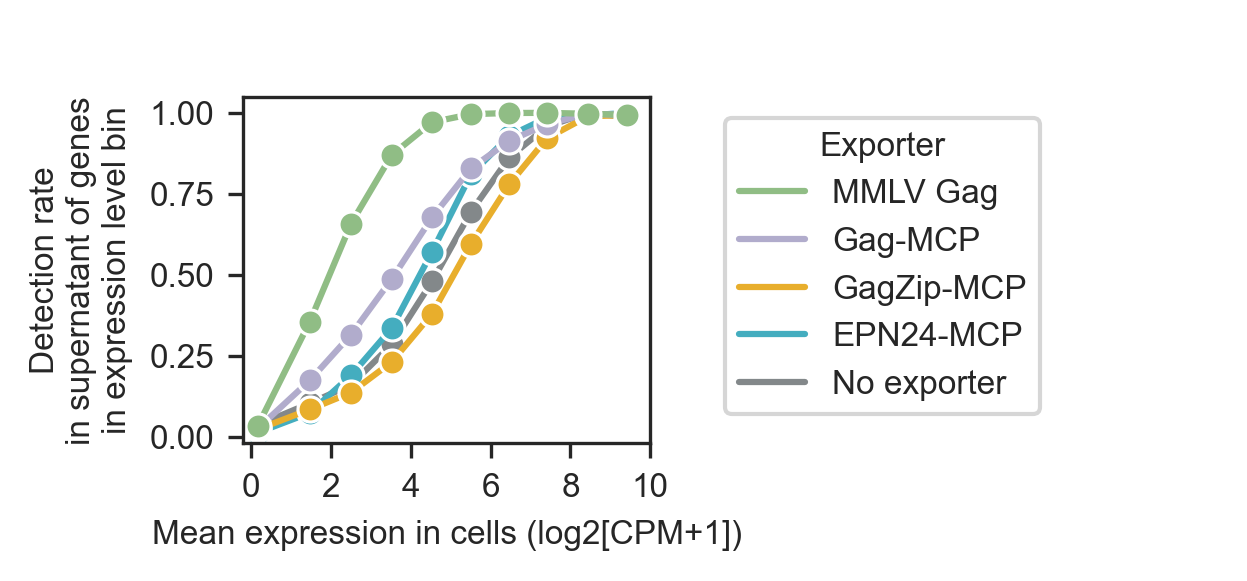

In [27]:
# Plot detection rate as a function of expression level

# Select subset of data
libs_to_select = ["sFH14_1", "sFH14_2", "sFH14_3", "sFH14_4", "sFH14_7"]
selector = det_rate["lib"].isin(libs_to_select)
data_subset = det_rate.loc[selector]

# Set sample colors
palette = ["#90bd85", "#b1accc", "#e8ae2c", "#44adbf", "#83888a"][::-1]

# Reorder to bring exporters to front
data_subset = data_subset.sort_values(by="lib", ascending=False)

# Plot

fig, ax = plt.subplots(1, 1, figsize=(1.75,1.5))

sns.lineplot(ax=ax,
             data=data_subset,
             x="mean_expr",
             y="p",
             hue="exporter_label",
             palette=palette,
             marker="o")

ax.set_xlim(-0.2, 10)
ax.set_ylim(-0.02, 1.05)

ax.set_xlabel("Mean expression in cells (log2[CPM+1])")
ax.set_ylabel("Detection rate\nin supernatant of genes\nin expression level bin")

ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticks([0, 2, 4, 6, 8, 10])
# ax.set_xticklabels([0, ])

ax.legend_.remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1.35, 0.7), title="Exporter")

save_figure(fig, "gene_detection_rate_by_expression_level_bin")